# Milestone 3 - SECOM Manufacturing

## Author - Lukas Fiorio

## Introduction

In this project we build upon the feature selection and predictive models that we started in Milestones 1 and 2.  Our goal is to predict manufacturing failures based on sensor readings that monitor the manufacturing process.

In Milestone 1 we used various feature selection techniques to reduce the dimensionality of our data to just the most useful predictors.

In Milestone 2 we went further to split our data into Train-Validate-Test sets for model evaluation using Decision Tree, Random Forest, and SVM classifier models.  We explored several hyper parameters for each and found that the Decision Tree performed the best, given our goal of catching defects (i.e. high recall; reasonable precision).

In this project, we will build neural network models and benchmark them against our Decision Tree from Milestone 2.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

# SFS stepwise selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import PredefinedHoldoutSplit

# feature reduction
from sklearn.feature_selection import mutual_info_regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# accuracy metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# multiple imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as rfc

# neural networks
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D

from joblib import dump, load # save/load model fitted models 
from itertools import product # cartesian product
from matplotlib.ticker import MaxNLocator # integer tick labels

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

## Read and merge data

This was handled and explained in more detail in Milestone 1.  Below is a summary of the steps taken:

- Inspected features and labels
  - Features were in a space-delimited (`" "`) txt file.  Loaded them into a dataframe.
  - Labels needed more customized loading (line-by-line into a list, parsing out extra fields and characters).
- Merged features and labels together into a dataframe.

In [3]:
# data sources, for loading
features_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

# load features into df
features = np.loadtxt(features_url)
features_df = pd.DataFrame(features)

# load labels data into list
labels_txt = urllib.request.urlopen(labels_url).read().splitlines()
labels = [] # empty list to store labels

# loop through labels, cleaning/splitting & appending to new list
for i in labels_txt:
    i = i.decode("utf-8").replace('"', '').split()
    labels.append(i) # append to list

# convert list to df
labels_df = pd.DataFrame(labels, columns = ['target', 'date', 'time'])

# properly type each column
labels_df['target'] = labels_df['target'].astype('int')
labels_df['date'] = pd.to_datetime(labels_df['date'])
labels_df['time'] = pd.to_timedelta(labels_df['time'])

# concat features & labels into df
secom_df = pd.concat([features_df, labels_df], axis=1)

## Clean and Prepare Data

In Milestone 1, we walked through several steps we took to clean our data (reducing the feature count in the process) *before* addressing class imbalance and feature selection methods.

Here, we've condensed those steps down.

- Drop duplicate columns \[104\] (and convert object columns back to numeric)
- Drop columns with only a single unique value \[12\]
- Drop columns with 80%+ null values \[8\]

In [4]:
### drop duplicate columns ###
secom_df = secom_df.T.drop_duplicates().T

# convert object columns back to numeric
obj_cols = secom_df.select_dtypes('object').columns
secom_df[obj_cols] = secom_df[obj_cols].astype(float)
secom_df['target'] = secom_df['target'].astype(int)

### drop columns w 1 unique val ###

# count of unique values by column
unique_val_cnt = secom_df.nunique().tolist()

# flag & drop columns with only 1 unique value
redundant_cols = secom_df.columns[np.where(np.array(unique_val_cnt)==1)[0]]
secom_df = secom_df.drop(redundant_cols, axis = 1)

### drop columns w 80%+ nulls ###

# flag & drop columns w >80% null values
high_null_cols = secom_df.T[(secom_df.isnull().sum() / secom_df.shape[0])>0.8].T.columns
secom_df = secom_df.drop(high_null_cols, 1)

Before going any further, we'll specify seeding to ensure replicability.

In [5]:
random_state = 99

# set seeds
seed(random_state)
tf.random.set_seed(random_state)

### Split data into Train-Validate-Test

In Milestone 2, we then split our data into train-validate-test before going any further to handle missing values, standardize data, and implement feature reduction techniques.

The validation set allows us to tune hyper parameters without introducing test set leakage.

We split the data into train-validate-test @ 80-10-10.

In [6]:
# specify target
target = 'target'

# drop unneeded timestamp data from labels
secom_df = secom_df.drop(['date', 'time'], axis = 1)

# separate df features and target
X = secom_df.copy().drop([target], axis = 1)
y = secom_df[target].copy()

# split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = random_state)

# split train into train-validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size = (1/9), 
                                                      random_state = random_state)

And we'll also reset the indices on each of our datasets to avoid issues with joining later on (during pre-processing).

In [7]:
# reset index to avoid issues with joining later on
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

### Handle missing values (multiple imputation estimator)

To deal with missing values we fit a multiple imputation estimator on the training data.  This filled our missing values based on the conditional distribution of the other features (based on cases that are **not** null).  It does not use the target's conditional distribution (this is to avoid leakage).

Alternatives considered were mean or median filling, or zero-filling (assuming a missing sensor reading is equivalent to a value of 0).  Since we do not know the data well enough to know *why* the records are missing, we don't feel comfortable zero-filling.

Mean or median filling is generally a less accurate way to fill missing values since it does not take into account changes in the conditional distribution of the other features.

The downsides to using this estimator are additional processing time (~5 minutes) and it still does not solve for bias inherent to the missing records themselves (i.e. certain records being more likely to be missing).

In [8]:
# limit to just 3 iterations (~5 minutes)
mice = IterativeImputer(max_iter = 3, random_state = random_state) # initialize imputer
mice.fit(X_train) # fit imputer

# dump(mice, 'models_lfiorio/mice.joblib') 

/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(max_iter=3, random_state=99)

And now we apply the fitted imputation estimator to each of our train-validate-test sets.

In [9]:
# pull out column names
X_cols = X.columns.tolist()

# make imputations
X_train = pd.DataFrame(mice.transform(X_train), columns = X_cols)
X_valid = pd.DataFrame(mice.transform(X_valid), columns = X_cols)
X_test = pd.DataFrame(mice.transform(X_test), columns = X_cols)

## Class imbalance

Examining class balance showed that manufacturing defects are a lot more rare than successes.  In real life, this is a good thing!  However, for our modeling we'll need to address this.

- `target = -1` (success)
- `target =  1` (failure)

In [10]:
# examine class imbalance
print("{:.2%}".format((y_train==1).mean()), 'of values')
print(y_train.value_counts())

6.70% of values
-1    1169
 1      84
Name: target, dtype: int64


### Motivation

Our data are heavily biased toward "success" (`target = -1`); only ~7% of observations are failures.  When we fit our model, we want to ensure that each class has equal importance/priority on the fit.

### Approach

To address class imbalance, we will use smote (**S**ynthetic **M**inority **O**versampling **TE**chnique) to interpolate our X features based on positive cases (where `target = 1`). 

We will address class imbalance in our training and validation sets, but **not** in our test set.  One issue with this approach is that performance on the validation set will not be as representative of actual performance in production (where data *will* be unbalanced).

We will address this by examining model performance on the test set across various accuracy metrics (precision, recall, etc).

#### Standardize the data

Since smote is based on a knn algorithm, we'll first standardize our features.  knn is strongly influenced by varying magnitudes across features since it is a distance-based algorithm.

In [11]:
# initialize and fit z-transform on features
znormalizer = StandardScaler()
znormalizer.fit(X_train)

# apply fitted transformation to features
X_train_znorm = pd.DataFrame(znormalizer.transform(X_train), columns = X_cols)
X_valid_znorm = pd.DataFrame(znormalizer.transform(X_valid), columns = X_cols)
X_test_znorm = pd.DataFrame(znormalizer.transform(X_test), columns = X_cols)

#### SMOTE

Now we'll implement smote to balance our target variable in the train and validation sets.  Quick verification now shows balanced classes.

In [12]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE and resample the minority class (y=1)
smote = SMOTE(random_state=random_state)
X_train_smote, y_train_smote = smote.fit_resample(X = X_train_znorm, y = y_train)
X_valid_smote, y_valid_smote = smote.fit_resample(X = X_valid_znorm, y = y_valid)

# confirm balanced classes
print(y_train_smote.value_counts().sort_index())
print(y_valid_smote.value_counts().sort_index())

-1    1169
 1    1169
Name: target, dtype: int64
-1    147
 1    147
Name: target, dtype: int64


## Feature selection

In Milestone 1, we used 3 feature selection techniques to reduce the dimensionality of our data.
- Filter (Mutual Information)
- Wrapper (Forward Selection)
- Embed (Lasso Regression)

There were a lot of decisions to make in the feature reduction process, but many columns could be eliminated without applying any feature selection methods at all.  Simply through the data cleaning above, we were able to eliminate over 100 columns.

We found relatively little intersection of the features selected using each method.  Almost 2/3 of the unique features selected across the methods were *only* selected by a single method.

In the end we reduced dimensionality to about 95 features, much less than the nearly 600 we started with.

The feature reduction process is implemented below.

### Mutual information

We started by calculating mutual information of each attribute with the target (using our class-balanced dataset).  We identified two natural threshold points on Mutual Information (0.1, 0.3).

Based on later analysis we determined that filtering to features with Mutual Information > 0.1 and uncorrelated with each other would be best.  We walk through those steps here.

In [13]:
# calculate mutual information w target
mi_score = mutual_info_regression(X_train_smote, y_train_smote, random_state=random_state)
mi_score_df = pd.DataFrame({'attribute': X_train_smote.columns, 'mi_score': mi_score})

# omit features whose M.I. with target is < 0.1
mid_mi_df = mi_score_df[mi_score_df['mi_score']>0.1]
mid_mi_cols = mid_mi_df['attribute'].tolist()

print('# of feature above M.I. threshold:', len(mid_mi_cols))

# of feature above M.I. threshold: 204


Since some of the selected features were highly correlated with each other, we also take the additional step to remove a degree of that dependence.  Independent features is a key assumption for linear models (such as SVM).

The below function calculates the correlation between each feature combination.  If the feature correlation is above a certain threshold (0.7), *one* (not both) of those columns is stored for removal.

In [14]:
def find_corr_features(df):

    corr_cols = []

    # check for MI within remaining features
    for col_i in df.columns:
        for col_j in df.columns:

            # compute MI for upper triangle
            if col_i < col_j:
                corr = df[col_i].corr(df[col_j]) 
                
                # store & print if above threshold
                if corr > 0.7:
                    corr_cols.append(col_i)

    return corr_cols

Apply this function to the features we identified above and then remove those that are highly correlated with each other. (~60 seconds)

In [15]:
# store columns with high correlation between each other
mid_mi_corr_cols = find_corr_features(X_train_smote[mid_mi_cols])

# remove duplicates from list of correlated columns
mid_mi_corr_cols = list(dict.fromkeys(mid_mi_corr_cols))

# keep only the features with low dependence on one another
mid_mi_cols = list(X_train_smote[mid_mi_cols].columns.difference(mid_mi_corr_cols, sort = False))

print('# of feature above M.I. threshold AND low dependence w each other:', len(mid_mi_cols))

# of feature above M.I. threshold AND low dependence w each other: 120


Keep only features with low dependence on one another.

### Forward selection

We use forward selection, continually adding one feature to a linear model and monitoring when to stop (based on error).

Based on the # of relevant features found in the filtering method above, we decided to stop after 200 steps.  This was more than enough to see when diminishing marginal returns set in.

To maintain consistency of model fitting on the training data based on the validation data, we take the extra step to temporarily combine the two back together for the `SFS` model, specifying the validation indices as our desired cross-validation split.

In [16]:
# temporarily combine the training ad validation sets
X_train_valid_smote = pd.concat([X_train_smote, X_valid_smote]).reset_index(drop = True)
y_train_valid_smote = y_train_smote.append(y_valid_smote).reset_index(drop = True)

# store validation set indices to pass to SFS
validation_index = np.array(range(X_train_smote.shape[0], X_train_valid_smote.shape[0]))

# define cv object for SFS
cv_split = PredefinedHoldoutSplit(validation_index)

Initialize the model and pass the indices from the validation set to be used for fitting

In [17]:
# initilize our estimator (w lin. reg. algorithm)
estimator = LinearRegression()

# specify stepwise params
stepwise_selector = SFS(estimator, 
    k_features = 200, # stop after 200 steps
    forward = True, 
    scoring = 'neg_mean_squared_error', # for regression
    cv = cv_split  # explicitly pass validation set indices
    )

#### *NOTE: Fitting the selector took about ~15 minutes to run*

- We download the fitted selector from my github repo and load it directly to save run-time.

### NOTE: The next code block will download a small zip file (<1MB) from the following github repo:

https://github.com/lukefiorio/secom

In [18]:
import os
import requests
import zipfile

# make directory to store fitted SFS model from milestone 1
if not os.path.exists('models_lfiorio'):
    os.makedirs('models_lfiorio')

# download the file if not already downloaded
if not os.path.isfile('models_lfiorio/secom-main/stepwise_selector.joblib'):
    
    # make API request to pull down github repo
    url = 'https://github.com/lukefiorio/secom/archive/main.zip'
    r = requests.get(url)

    # set file path, name
    file_name = 'models_lfiorio/models.zip'

    # write zip file
    with open(file_name, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

    # unzip the file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('models_lfiorio')

    # remove the original zipped file
    os.remove(file_name)

*Original code used to fit the stepwise selector*

In [19]:
# # train selector
# stepwise_selector = stepwise_selector.fit(X_train_valid_smote, y_train_valid_smote)
# dump(stepwise_selector, 'models_lfiorio/stepwise_selector.joblib') 

And now simply load the downloaded file

In [20]:
# load fitted imputation model
stepwise_selector = load('models_lfiorio/secom-main/stepwise_selector.joblib') 

### Find the best Forward Selection model.

The best step was the one with the lowest abs. error. We took this extra step to identify the best step since we specified `k_features = 200` (rather than using "parsimonious") 

In [21]:
# set default values
best_step = 0
error = -999999

# loop through step scores to find best step
for i in stepwise_selector.get_metric_dict():
    i_error = stepwise_selector.get_metric_dict()[i]['avg_score']
    if i_error > error:
        best_step = i
        error = i_error

/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Store features from the best step and read out the count (135).

In [22]:
# store info on best step
# best_step = best_selector.shape[1] # nbr of features in best step
best_step_metrics = stepwise_selector.get_metric_dict()[best_step] # store dict of best model
best_step_features = list(best_step_metrics['feature_names']) # access dict: feature names

# show best model step & features
print('feature cnt:', best_step)
# best_step_features

feature cnt: 135


### Lasso Regression

Lasso Regression adds a penalty term based on the absolute value of the coefficients on each feature.  As the penalty term gets bigger, more & more of the features used have their coefficients shrink to 0.

Almost immediately (alpha = 0.01), the # of features get cut in half.  Around alpha = 0.025 the # of features start to hit an inflection point.  Not until about alpha = 0.1 does the # of features remaining begin to stabilize a bit.

Run Lasso Regression once for each value of alpha and store the coefficients.

In [23]:
# seq of penalty values ('alphas') to try
alphas = np.linspace(0.003125, 0.15, 48)
num_coefs = X_train_smote.shape[1]

# Store coefficients for each alpha:
coef_cols = [i for i in X_train_smote.columns] + ['intercept']
alpha_df = pd.DataFrame(columns=coef_cols)

for a in alphas:
    # Fit model
    clf_temp = linear_model.Lasso(alpha=a, tol=0.1, random_state = random_state)
    clf_temp.fit(X_train_smote, y_train_smote)
    # Get coefficients + intercept
    coef_nums = np.append(clf_temp.coef_, clf_temp.intercept_)

    alpha_df = alpha_df.append(dict(zip(coef_cols, coef_nums)), ignore_index=True)

# set index values to penalty terms
alpha_df.index = alphas

We selected the model with regularization penalty (alpha) = 0.025 and stored the features that had non-zero coefficients (132).

In [24]:
lasso_cols = alpha_df.loc[0.025]
lasso_cols = list(lasso_cols[lasso_cols != 0].index)

# remove the intercept column from the list
del lasso_cols[-1]

print('feature cnt:', len(lasso_cols))

feature cnt: 132


### Combining the Feature Selection Methods

Using the above techniques, we settled on a set of potential features to keep.  We then examined the number of features kept by each method as well as their overlap.

Using our judgement, we kept features that appeared in **at least** two of the three methods.  This came out to 95 features.

In [25]:
from collections import Counter

# combine selected features into large list (with dupes)
features_list = mid_mi_cols + best_step_features + lasso_cols

# apply counter to count # of occurences of each feature (while de-duping)
feature_cnt_dict = Counter(features_list)
feature_cnt_df = pd.DataFrame.from_dict(feature_cnt_dict, orient='index').reset_index()

# selected features
selected_features = list(feature_cnt_df['index'][feature_cnt_df[0]>1])

print('# of selected features for modeling:', len(selected_features))

# of selected features for modeling: 95


## Modeling

### Benchmark model - Decision Tree

In Milestone 2 we built the following models to predict manufacturing errors:

- **Decision Tree** *(best model)*
- Random Forest
- SVM Classifier

Before building Neural Network models, we'll recreate our best model (Decision Tree) from that project.

We'll start by filtering our train-validate-test sets down to just the features we selected above.

In [26]:
# filter our train-validate-test data to just our selected features
X_train_reduced = X_train_smote[selected_features]
X_valid_reduced = X_valid_smote[selected_features]
X_test_reduced = X_test_znorm[selected_features]

And now we'll fit the model using our best hyperparameters from Milestone 2.
- `max_leaf_nodes = 30`
- `min_samples_leaf = 10`
- `max_depth = 5`

In addition to fitting the model, we'll also continue on to make predictions on the test set to remind ourselves of our benchmark.

In [27]:
# best model: Decision Tree
tree = DecisionTreeClassifier(criterion = 'gini', 
                              random_state = random_state, 
                              max_leaf_nodes = 30,
                              min_samples_leaf = 10,
                              max_depth = 5)

# fit model
tree.fit(X_train_reduced, y_train_smote)

# make predictions on the test set
y_test_hat_tree = tree.predict(X_test_reduced)

To evaluate our Decision Tree we'll define functions to clearly present our accuracy metrics and the confusion matrix.

We'll start with a function for the accuracy report (f1, precision, recall, etc.).

In [28]:
def accuracy_report(y, y_hat):
    
    # store accuracy metrics (f1, precision, recall, accuracy, + full report)
    f1 = f1_score(y, y_hat, pos_label = 1)
    precision = precision_score(y, y_hat, pos_label = 1)
    recall = recall_score(y, y_hat, pos_label = 1)
    accuracy = accuracy_score(y, y_hat)
    class_rpt = classification_report(y, y_hat, zero_division = 0)
    
    # print accuracy measures
    print("f1: ", round(f1, 4))
    print("precision: ", round(precision, 4))
    print("recall: ", round(recall, 4))
    print("accuracy: ", round(accuracy, 4))
    print("==================================")
    print(class_rpt)

And now define our confusion matrix function.

In [29]:
def format_cm(y, y_hat, title, labels, norm):
    ''' norm = { 'true', 'pred', 'all', None }'''
    
    # store (normalized) confusion matrix
    cm = np.round(confusion_matrix(y, y_hat, normalize = norm), 3)

    # configure confusion matrix plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # show plot and confusion matrix
    plt.show()
    print(cm)

#### Evaluate Decision Tree Accuracy

We notice that while the Decision Tree model has only modest accuracy (`0.79`), it *does* have relatively highest recall on the positive class (manufacturing failures) given the class imbalance. At `0.60` the recall was noticeably better than our other two models (`0.20` each).

The precision on the Decision Tree model is a bit low on the positive class (`0.17`), but not to an untenable degree given our purpose. Consider a human auditor checking "flagged" diapers and finding a true defect one-in-six times.

Given the relatively low prevalence of failures, and the higher cost of missing a failure than "missing" a success... this seems like a reasonable benchmark to start from.

In [30]:
# accuracy metrics: Decision Tree
accuracy_report(y_test, y_test_hat_tree)

f1:  0.2667
precision:  0.1714
recall:  0.6
accuracy:  0.7898
              precision    recall  f1-score   support

          -1       0.97      0.80      0.88       147
           1       0.17      0.60      0.27        10

    accuracy                           0.79       157
   macro avg       0.57      0.70      0.57       157
weighted avg       0.92      0.79      0.84       157



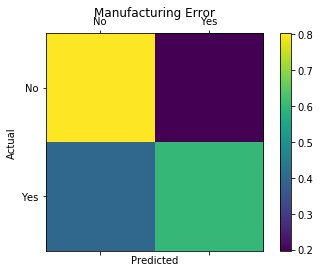

[[0.803 0.197]
 [0.4   0.6  ]]


In [31]:
# confusion matrix: Decision Tree
format_cm(y_test, y_test_hat_tree, "Manufacturing Error", ["No", "Yes"], "true")

### Neural Networks

We want to test out a few different training parameters, so we'll start by defining a function that build an artificial neural network (ANN) for prediction on our binary target (red/white wine).

We pass in data to train and test on, and specify:
- \# of epochs
- batch size
- learning rate
- hidden layers (depth AND size)
- dropout rate (optional)

Between hidden layers, we'll use a ReLU activation function (Rectified Linear Unit. `max(0, x)`).  In our final output layer, we'll use a sigmoid activation function.

We center our initial weights around 0 (random `~N(0, 1)`) and our bias terms at 0.  Since we've standardized our data, this should be a reasonable starting point.

In [32]:
def ann_binary(X_train, y_train, X_test, y_test, 
               epochs, batch_size, learning_rate, hidden_layers, 
               dropout=0, verbose=1):
    '''
    epochs. int: # of training epochs
    batch_size. int: # of observations per training batch
    learning_rate. float: initial learning rate of NN
    hidden_layers. [int]: array of hidden node sizes
    dropout. float: percent of nodes to force-zero in each hidden layer
    verbose. int: whether to display fitting progress (0, 1)
    '''
    
    # clear pre-existing models if needed
    tf.keras.backend.clear_session()
    
    # cnt of features
    n_features = X_train.shape[1]
    
    # initialize model
    model = tf.keras.Sequential()
    
    # Add layers sequentially
    for h_index, h_val in enumerate(hidden_layers):

        # hidden layer 1
        if h_index == 0:
            
            # dense layer, with input dimensions set
            model.add(Dense(
                units = h_val, 
                activation='relu', 
                kernel_initializer='random_normal', 
                input_shape=(n_features,)
            ))

        # hidden layers 2 thru n
        else:
            
            # dense layer, input dimensions inferred
            model.add(Dense(
                units = h_val, 
                activation='relu',
                kernel_initializer='random_normal'
            ))
            
            # if dropout was specified, apply it here
            if (0 < dropout < 1): model.add(Dropout(rate=dropout))

    # add final (output) layer
    model.add(Dense(units = 1, activation='sigmoid'))

    # Setup model with ADAM optimization and cross entropy loss.
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # fit the model and validate against a test set
    model_logs = model.fit(X_train, y_train,
                           epochs = epochs,
                           batch_size = batch_size,
                           validation_data = (X_test, y_test), 
                           verbose = verbose
                          )
    
    # return the model itself AND the accuracy logs
    return model, model_logs

And we also define a function to help visualize how the neural network is learning over each epoch. We'll also report out how its final epoch performs on a validation set.

In [33]:
def model_plots(model, test_set="Test"):

    # cnt of epochs
    epochs = len(model.history['accuracy'])
    final_valid_acc = model.history['val_accuracy'][epochs-1]
    final_valid_loss = model.history['val_loss'][epochs-1]
    
    # set figure, axis properties
    fig, ax = plt.subplots(ncols = 2, nrows = 1)
    fig.set_size_inches(16, 4)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # make accuracy plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['accuracy'], ax = ax[0], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_accuracy'], ax = ax[0], label = test_set);
    ax[0].title.set_text('Model Accuracy');
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_xlabel('Epochs')
    ax[0].legend();
    
    # make loss plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['loss'], ax = ax[1], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_loss'], ax = ax[1], label = test_set);
    ax[1].title.set_text('Model Loss');
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlabel('Epochs')
    ax[1].legend();
    
    # print final stats
    print('\n', test_set, 'Accuracy:', round(final_valid_acc, 3),'\n', test_set, 'Loss:', round(final_valid_loss, 3))

And before doing any training, let's make sure to map our target to `(0, 1)`.  We had been using a `(-1, 1)` mapping to assist with SVM fitting earlier, but need to make sure the target is as tensorflow expects!

In [34]:
y_train_smote_nn = y_train_smote.map({-1:0, 1:1})
y_valid_smote_nn = y_valid_smote.map({-1:0, 1:1})
y_test_nn = y_test.map({-1:0, 1:1})

After trying out a few models, we find one that appears to learn without suffering too heavily from overfitting.

Our network learns over 25 epochs, with learning rate of 0.002 (just above the default of 0.001).  We have 2 hidden layers (of size 8, 4), with very high dropout (0.75) to help regularize the model.

We hide the output, for brevity sake.

In [35]:
# fit model and store logs
ann_model, ann_model_logs = ann_binary(
    X_train = X_train_reduced,
    y_train = y_train_smote_nn,
    X_test = X_valid_reduced,
    y_test = y_valid_smote_nn,
    epochs = 25,
    batch_size = 1024,
    learning_rate = 0.002,
    hidden_layers = [8, 4],
    dropout = 0.75,
    verbose = 0
    )  

Looking at how the model learned, it's a bit choppy, but we do appear to see gradual improvement over time.  Accuracy on the \[balanced\] validation set comes in around 62%.  Looking back to our Milestone 2 results, our Decision Tree had 59% accuracy on the \[balanced\] validation set; so it appears we may have seen slight improvement.

Of course, the test accuracy is what's important so we'll examine that next.


 Validation Accuracy: 0.616 
 Validation Loss: 0.658


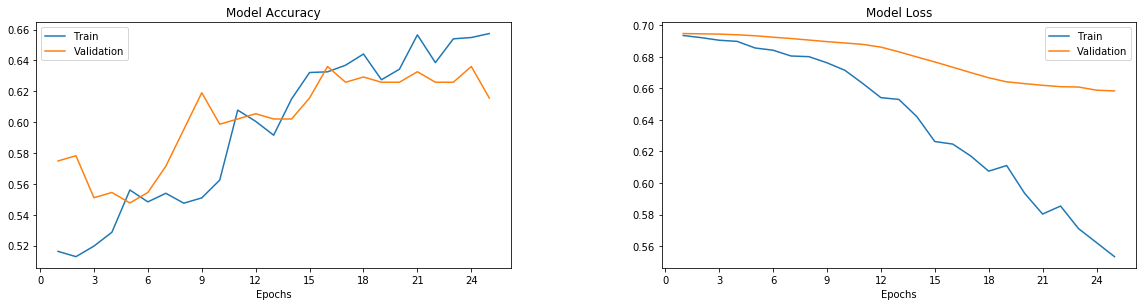

In [36]:
model_plots(ann_model_logs, test_set = "Validation")

Next we make predictions and evaluate overall accuracy.  There are few things worth noting here.

First is that our test accuracy was 82.2%, which is an improvement over our decision tree which had 79% accuracy. This is the accuracy on the actual production data (we did not adjust for class imbalance in our test data).

We also notice that our train set accuracy is actually much higher (89.5%) than during our neural network training (65.7%)... this is because of our dropout regularization.  The predictions below aren't randomly dropping some of our weights when making the prediction.

Lastly, we also note that the validation accuracy is different (lower) than test accuracy, partly due to randomness and leakage, but mostly due to differences in class balance.

In [37]:
# make soft predictions (probabilities)
y_train_hat_ann = ann_model.predict(X_train_reduced)
y_valid_hat_ann = ann_model.predict(X_valid_reduced)
y_test_hat_ann = ann_model.predict(X_test_reduced)

# calculate accuracy
train_acc_nn = accuracy_score(np.round(np.squeeze(y_train_hat_ann)), y_train_smote_nn)
valid_acc_nn = accuracy_score(np.round(np.squeeze(y_valid_hat_ann)), y_valid_smote_nn)
test_acc_nn = accuracy_score(np.round(np.squeeze(y_test_hat_ann)), y_test_nn)

# print results
print("Accuracy - Train:", np.round(train_acc_nn, 3))
print("Accuracy - Valid:", np.round(valid_acc_nn, 3))
print("Accuracy -  Test:", np.round(test_acc_nn, 3))

Accuracy - Train: 0.895
Accuracy - Valid: 0.616
Accuracy -  Test: 0.822


Examining the accuracy report and confusion matrix, we see that we still achieved 60% recall on defective products, albeit with slightly better precision (20% vs 17%).  That's to say that the QA team would still catch just as many of the defects, but with this model one-in-five of inspected products would be defective (as opposed to one-in-six with the decision tree).

In [38]:
# accuracy metrics: Neural Network
accuracy_report(y_test_nn, np.round(y_test_hat_ann))

f1:  0.3
precision:  0.2
recall:  0.6
accuracy:  0.8217
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       147
           1       0.20      0.60      0.30        10

    accuracy                           0.82       157
   macro avg       0.58      0.72      0.60       157
weighted avg       0.92      0.82      0.86       157



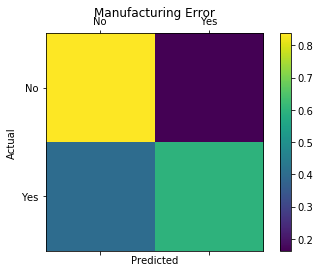

[[0.837 0.163]
 [0.4   0.6  ]]


In [39]:
# confusion matrix: Neural Network
format_cm(y_test_nn, np.round(y_test_hat_ann), "Manufacturing Error", ["No", "Yes"], "true")

### Convolutional Neural Network (CNN)

For our next model we will build a **1D convolutional** neural network (CNN). Our CNN model will iterate sequentially through our best features (the ones we reduced to earlier) using smoothing windows.

We choose to try a CNN model here rather than RNN (recurrent NN) because we expect that a CNN will be better able to propagate weights forward (RNN has a tendency to "forget" as it goes).

#### Reshape data

We'll start by reshaping our X datasets (features) to add a dimension.  For a 1D CNN, Keras assumes that we will have two-dimensional data, so we'll add a dummy dimension to accommodate that.

In [40]:
# extract shape info (features, rows)
n_obs_train, n_features = X_train_reduced.shape
n_obs_valid = X_valid_reduced.shape[0]
n_obs_test = X_test_reduced.shape[0]

# reshape our features data to add a dimension (for CNN)
XC_train_reduced = X_train_reduced.values.reshape(n_obs_train, n_features, 1)
XC_valid_reduced = X_valid_reduced.values.reshape(n_obs_valid, n_features, 1)
XC_test_reduced = X_test_reduced.values.reshape(n_obs_test, n_features, 1)

#### Build Model

After trying a few different combinations, we build the following CNN model.  It consists of 2 hidden layers, with a ReLU activation function on each.  We also apply max pooling between the two hidden layers to smooth our output.

To help with regularization, we also apply L2 kernel regularization on each of our hidden layers, which a much higher penalty on our first layer.

We flatten back to 1D before adding our final output layer (which is activated by a sigmoid).  We specify `units = 1` because this is a binary classification problem.

In [41]:
# clear model (if necessary)
tf.keras.backend.clear_session()

# initialize model
cnn_model = tf.keras.Sequential()

# add convolutional layer
cnn_model.add(Conv1D(filters = 64,  # output 64 sets of weights 
                     kernel_size = 8, # fit (64 * 8) + (64) = 576 weights
                     strides = 2,
                     padding = 'same',
                     input_shape = (n_features, 1), # accept 95x1 matrix
                     activation = 'relu',
                     kernel_regularizer=regularizers.l2(l = 0.5), # apply hefty regularization
                     data_format = 'channels_last'
                    ))

# add condensed layer (via max pooling) 
cnn_model.add(MaxPooling1D(pool_size = 2, strides = 1))

# add convolutional layer
cnn_model.add(Conv1D(filters = 16,  # output 16 sets of weights 
                     kernel_size = 2, # fit (16 * 2) + (16) = 6,176 weights
                     dilation_rate = 1,
                     padding = 'same',
                     input_shape = (n_features, 1), # accept 95x1
                     activation = 'relu',
                     kernel_regularizer=regularizers.l2(l = 0.05), # apply light regularization
                     data_format = 'channels_last'
                    ))

# flatten back to 1d
cnn_model.add(Flatten())

# add our output layer
cnn_model.add(Dense(units = 1, activation = 'sigmoid'))

From our model summary, we can see how the above calculations played out.

- In our initial layer, the output shape is 48x64.  The 48 comes from the number of iterations the filter makes on each observation (95 features at stride 2 > 48 steps).  The 64 is from our chosen # of filters.
- The # of parameters is 576.  This comes from our (64 filters * 8 kernels size) + 64 bias terms. 
- Max Pooling decreases the 48 steps to 47 (at stride 1, pooling by 2 only reduces steps by 1); it does not affect the # of filters.
- At our next hidden layer, we output 2,064 parameters.  This comes from the prior dimensions (64) * filters (16) * kernel size (2) + 16 bias terms.
- Flattening results in 752 features (47 * 16 from our Max Pooling shape)
- Finally, our last layer has 753 parameters (752 + 1 bias)

In [42]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            576       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 47, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 16)            2064      
_________________________________________________________________
flatten (Flatten)            (None, 752)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 753       
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


#### Fit Model

Next we fit our model on our reshaped data.  We apply the default learning rate of `0.001` and much smaller batch size of `64` (compared `1024` in our first neural network).

In [43]:
# initialize
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

# fit model
cnn_model_logs = cnn_model.fit(XC_train_reduced, y_train_smote_nn,
                               epochs=10,
                               batch_size=64,
                               validation_data=(XC_valid_reduced, y_valid_smote_nn),
                               verbose = 0)

#### Validation Accuracy

Looking at how this model learned, the increase is also a bit choppy, but the loss (on both training and validation) decreases smoothly.  There is some overfitting (accuracy on the train dataset appears to be 5-10% better than on validation), but not too drastic.

Comparing accuracy on the \[balanced\] validation from this model (69%) to our prior models, it looks like we could see modest improvement on our test set.  Our prior two models (Tree, NN) had validation accuracy of 59% and 62%, respectively. 

Of course, the test accuracy is what's important so we'll examine that next.


 Validation Accuracy: 0.687 
 Validation Loss: 0.695


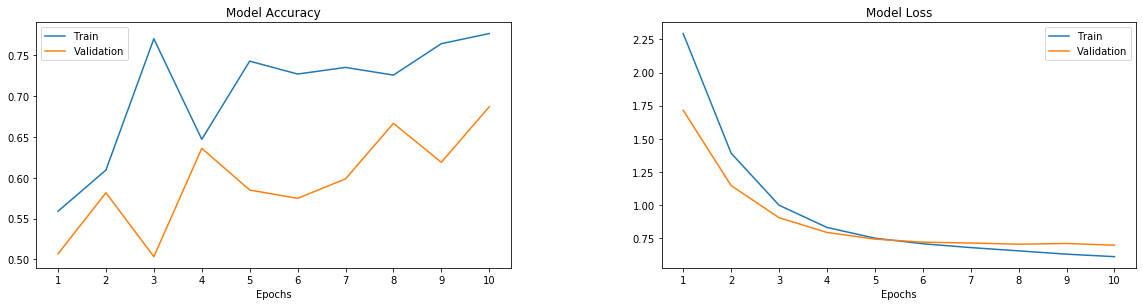

In [44]:
model_plots(cnn_model_logs, test_set = "Validation")

#### Test Accuracy

Next we make predictions and evaluate overall accuracy.

We note that our test accuracy was 69.4%, which is noticeably worse than our decision tree and NN models (79%, 82%, respectively).  This isn't a great omen, but perhaps our model gets better recall on our positive class (manufacturing defects), which is what we're most interested in detecting.

In [45]:
# make soft predictions (probabilities)
y_train_hat_cnn = cnn_model.predict(XC_train_reduced)
y_valid_hat_cnn = cnn_model.predict(XC_valid_reduced)
y_test_hat_cnn = cnn_model.predict(XC_test_reduced)

# calculate accuracy
train_acc_cnn = accuracy_score(np.round(np.squeeze(y_train_hat_cnn)), y_train_smote_nn)
valid_acc_cnn = accuracy_score(np.round(np.squeeze(y_valid_hat_cnn)), y_valid_smote_nn)
test_acc_cnn = accuracy_score(np.round(np.squeeze(y_test_hat_cnn)), y_test_nn)

# print results
print("Accuracy - Train:", np.round(train_acc_cnn, 3))
print("Accuracy - Valid:", np.round(valid_acc_cnn, 3))
print("Accuracy -  Test:", np.round(test_acc_cnn, 3))

Accuracy - Train: 0.775
Accuracy - Valid: 0.687
Accuracy -  Test: 0.694


Taking a look at the accuracy report and confusion matrix, we see that this model is just a bit worse all around.  Our recall on defective products is 50%, with precision of only 10%.  So using this model, we'd identify half of defective products, but only one-in-ten flagged products would actually be defective.  Not great!

In [46]:
# accuracy metrics: Neural Network
accuracy_report(y_test_nn, np.round(y_test_hat_cnn))

f1:  0.1724
precision:  0.1042
recall:  0.5
accuracy:  0.6943
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       147
           1       0.10      0.50      0.17        10

    accuracy                           0.69       157
   macro avg       0.53      0.60      0.49       157
weighted avg       0.90      0.69      0.77       157



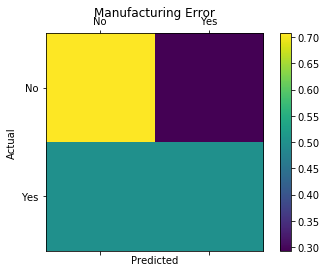

[[0.707 0.293]
 [0.5   0.5  ]]


In [47]:
# confusion matrix: Convolutional Neural Network
format_cm(y_test_nn, np.round(y_test_hat_cnn), "Manufacturing Error", ["No", "Yes"], "true")

## Summary

We've now built various models using both traditional ML modeling approaches as well as Deep Learning techniques (i.e. neural networks).

Based on the overall accuracy on our validation set, our best performing model was the Convolutional Neural Network.  However upon evaluation of our models on the test set, we saw that our CNN model had noticeably lower accuracy than expected.  This may have occurred through various attempts at model tuning, before we - just by chance - arrived at model that did well on validation, without being more broadly generalizable.

As discussed in Milestone 2, our main goal with this model should be to identify as many defective products as possible, without overwhelming the Quality Check Team/Process.  By that criteria, both the Decision Tree and our first neural network performed better on the test data (higher positive recall and precision).

In the end, using the CNN model, we would expect an overall accuracy of `69.4%`, and catching `50%` of all defects (with `10%` of flagged defects *actually* being defective).

Had we chosen the Decision Tree, we would've obtained an overall accuracy of `79%`, while catching `60%` of all defects (with `17%` of flagged products actually being defective).

And last, had we chosen our first Neural Network, we would've obtained an overall accuracy of `82%`, while catching `60%` of all defects (with `20%` of flagged products actually being defective).